# PyTorch Multiple Regression

1. Ceate a model
2. Choose a loss function
3. Define a dataset
4. Set an optimizer
5. Train
* 5.1. Looping through the dataset
* 5.2. Calculating the loss (Forward Pass)
* 5.3. Computing gradients (Backpropagation)
* 5.4. Updating model parameters.

In [4]:
!pip install ucimlrepo feature_engine torchmetrics --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.0/230.0 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 53.5 MB/s eta 0:00:00


In [5]:
# Imports
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
from feature_engine.encoding import OneHotEncoder
from sklearn.metrics import root_mean_squared_error

In [6]:
# Data Load
from ucimlrepo import fetch_ucirepo

# fetch dataset
abalone = fetch_ucirepo(id=1)

# data (as pandas dataframes)
X = abalone.data.features
y = abalone.data.targets

# One Hot Encode Sex
ohe = OneHotEncoder(variables=['Sex'])
X = ohe.fit_transform(X)

# Second Order Variables
X['Diameter_2'] = X['Diameter'] ** 2
X['Height_2'] = X['Height'] ** 2
X['Shell_2'] = X['Shell_weight'] ** 2

# Drop Whole Weight (multicolinearity)
X.drop(['Whole_weight', 'Length'], axis=1, inplace=True)

# View
df = pd.concat([X,y], axis=1)

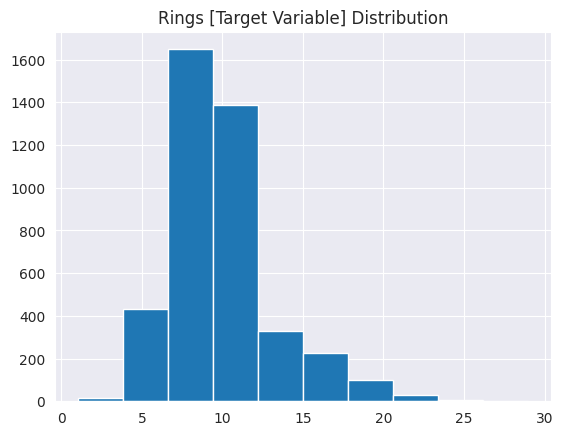

In [7]:
# Looking at our Target variable
plt.hist(y)
plt.title('Rings [Target Variable] Distribution');

In [46]:
# Statistical description
df.describe()

,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Sex_M,Sex_F,Sex_I,Rings
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,0.523992,0.407881,0.139516,0.828742,0.359367,0.180594,0.238831,0.365813,0.312904,0.321283,9.933684
std,0.120093,0.099240,0.041827,0.490389,0.221963,0.109614,0.139203,0.481715,0.463731,0.467025,3.224169
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,0.000000,0.000000,0.000000,1.000000
25%,0.450000,0.350000,0.115000,0.441500,0.186000,0.093500,0.130000,0.000000,0.000000,0.000000,8.000000
50%,0.545000,0.425000,0.140000,0.799500,0.336000,0.171000,0.234000,0.000000,0.000000,0.000000,9.000000
75%,0.615000,0.480000,0.165000,1.153000,0.502000,0.253000,0.329000,1.000000,1.000000,1.000000,11.000000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,1.000000,1.000000,1.000000,29.000000


In [50]:
# Looking at the correlations
df.query('outliers != -1').drop(['Sex_M', 'Sex_I', 'Sex_F', 'outliers'],axis=1).corr().style.background_gradient(cmap='coolwarm')

,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
Length,1.000000,0.986812,0.827554,0.925261,0.897914,0.903018,0.897706,0.556720
Diameter,0.986812,1.000000,0.833684,0.925452,0.893162,0.899724,0.905330,0.574660
Height,0.827554,0.833684,1.000000,0.819221,0.774972,0.798319,0.817338,0.557467
Whole_weight,0.925261,0.925452,0.819221,1.000000,0.969405,0.966375,0.955355,0.540390
Shucked_weight,0.897914,0.893162,0.774972,0.969405,1.000000,0.931961,0.882617,0.420884
Viscera_weight,0.903018,0.899724,0.798319,0.966375,0.931961,1.000000,0.907656,0.503819
Shell_weight,0.897706,0.905330,0.817338,0.955355,0.882617,0.907656,1.000000,0.627574
Rings,0.556720,0.574660,0.557467,0.540390,0.420884,0.503819,0.627574,1.000000


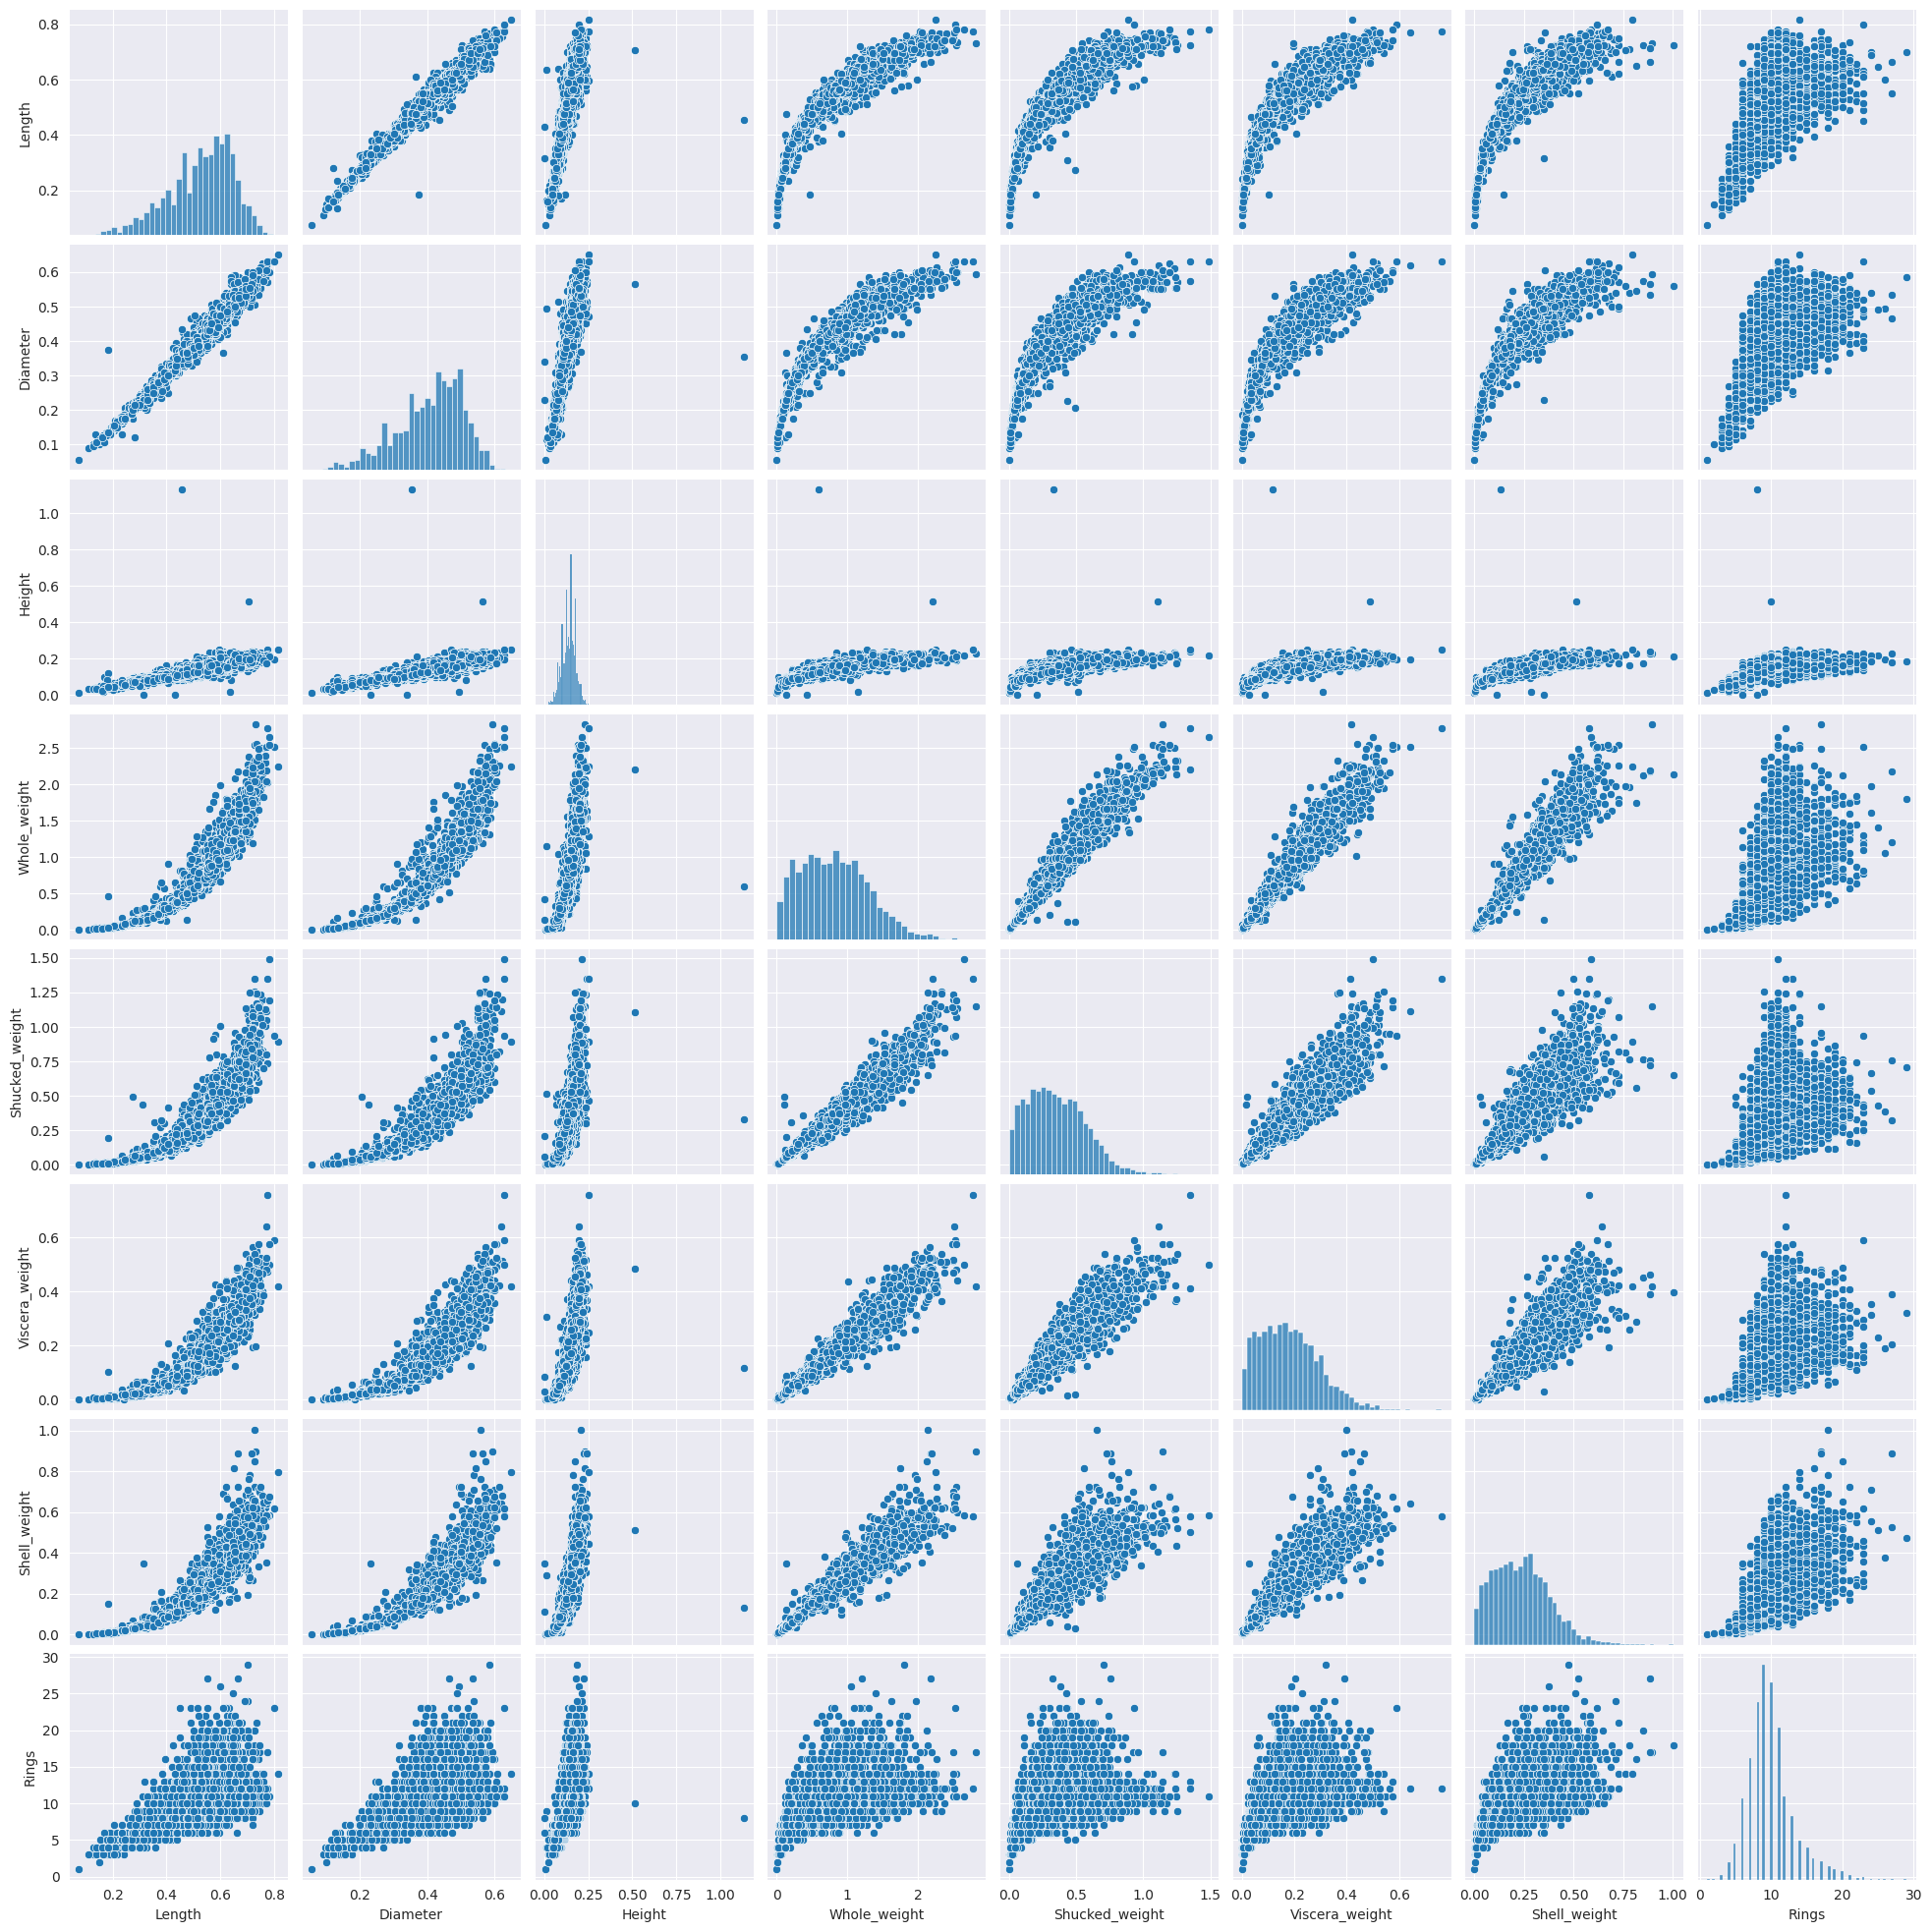

In [ ]:
sns.pairplot(df);

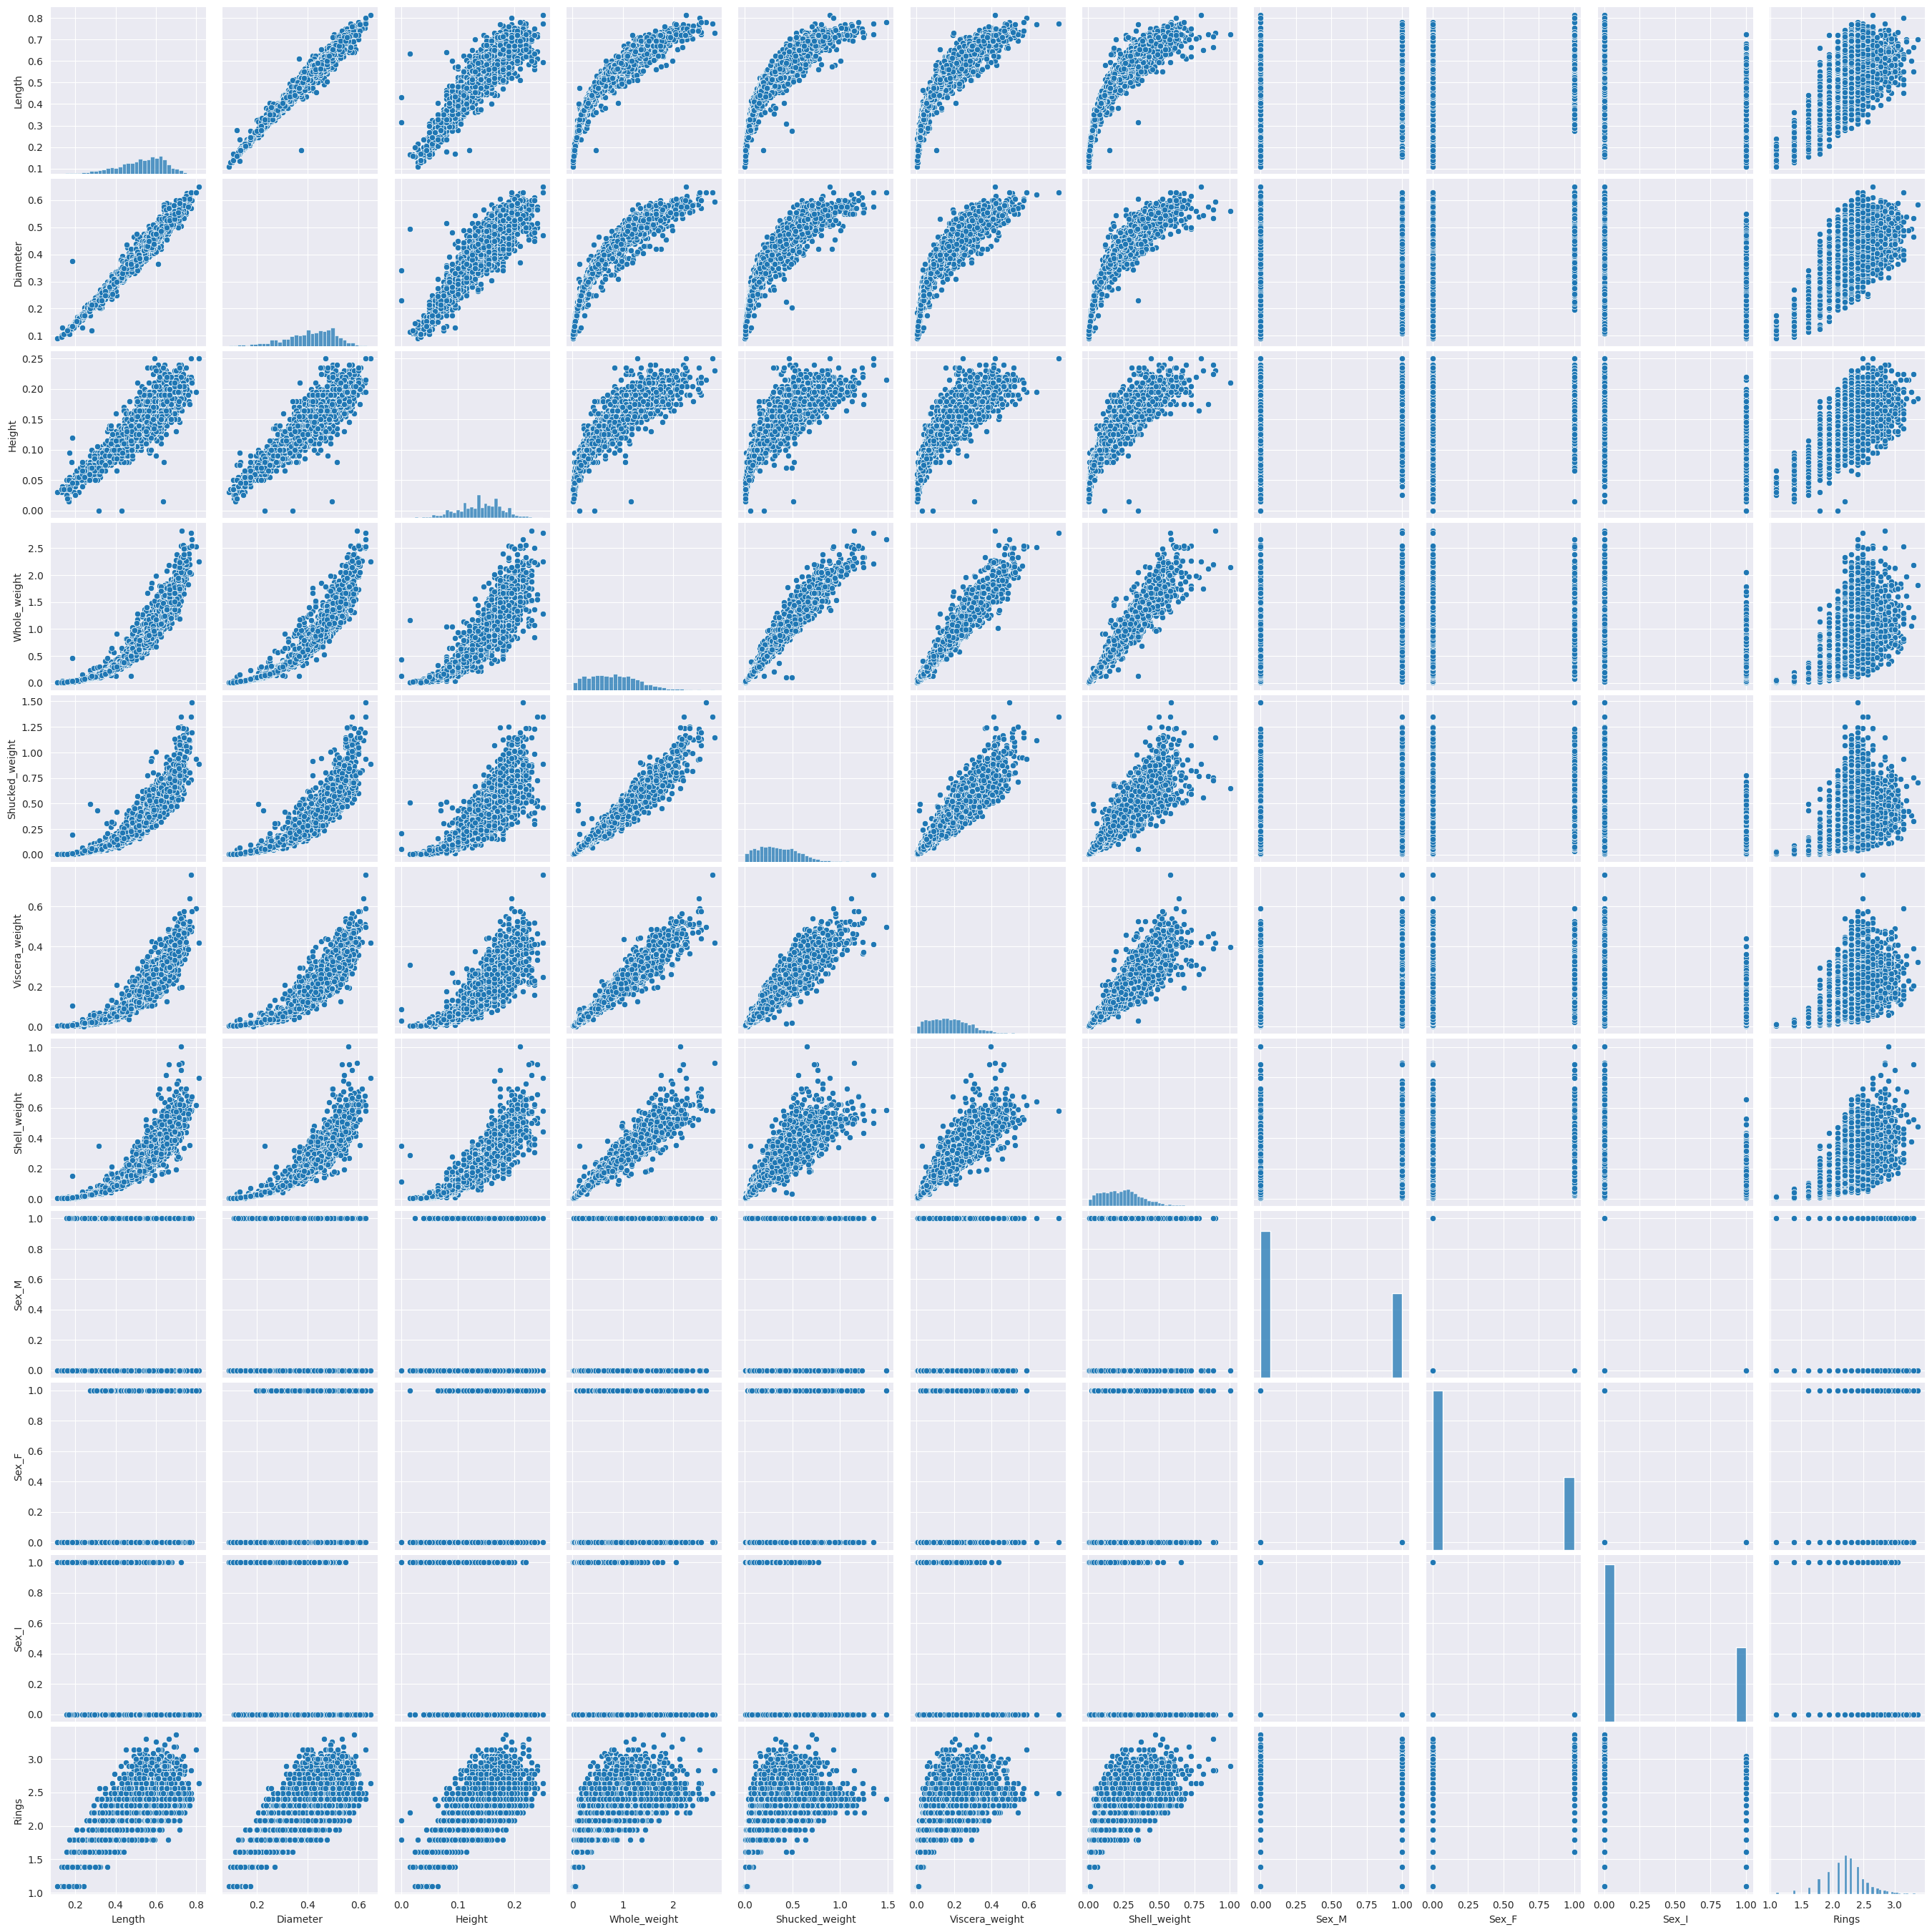

In [52]:
df2 = df.query('Height < 0.3 and Rings > 2').copy()
df2['Rings'] = np.log(df2['Rings'])
sns.pairplot(df2);

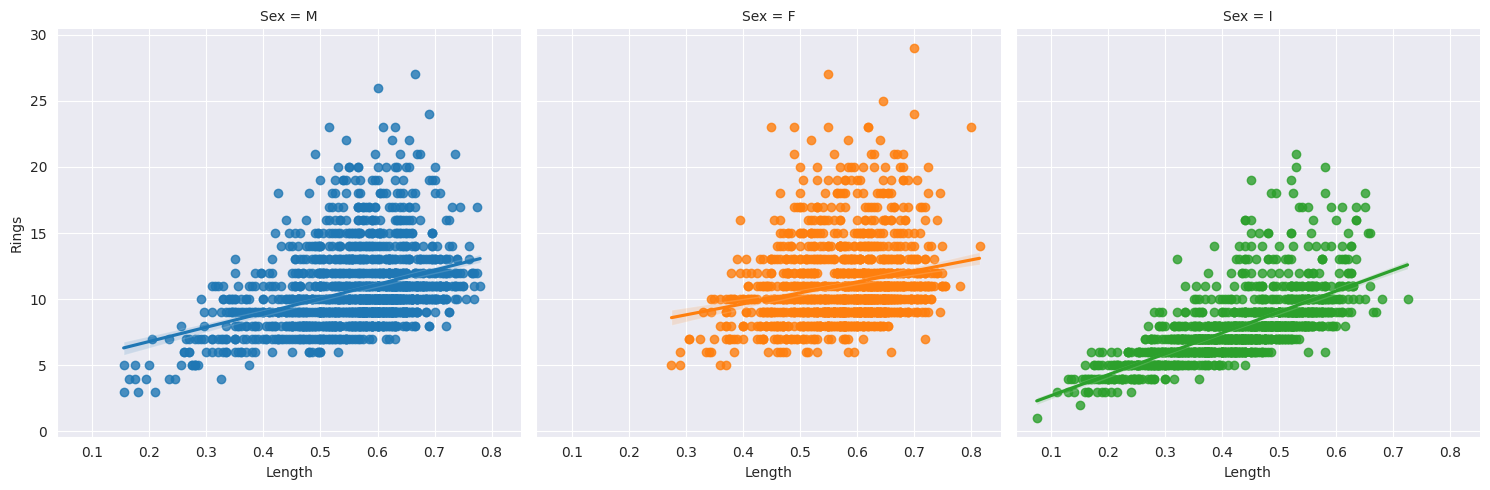

In [ ]:
# Create a FacetGrid with scatterplots
sns.lmplot(x="Length", y="Rings", hue="Sex", col="Sex", data=df);

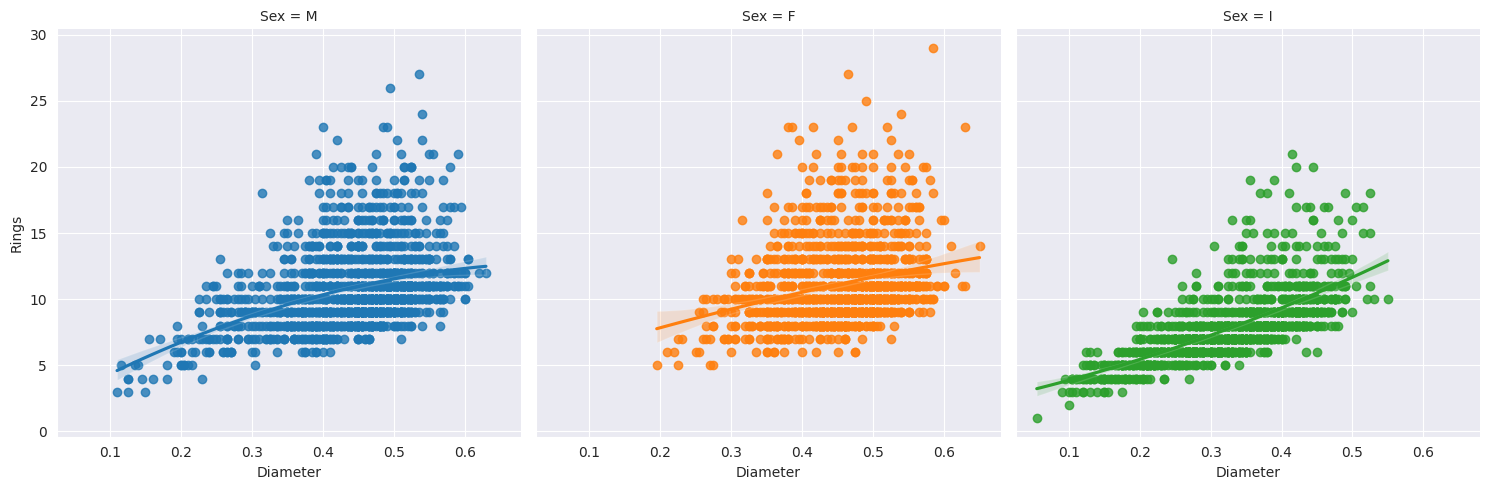

In [ ]:
# Create a FacetGrid with scatterplots
sns.lmplot(x="Diameter", y="Rings", hue="Sex", col="Sex", order=2, data=df);

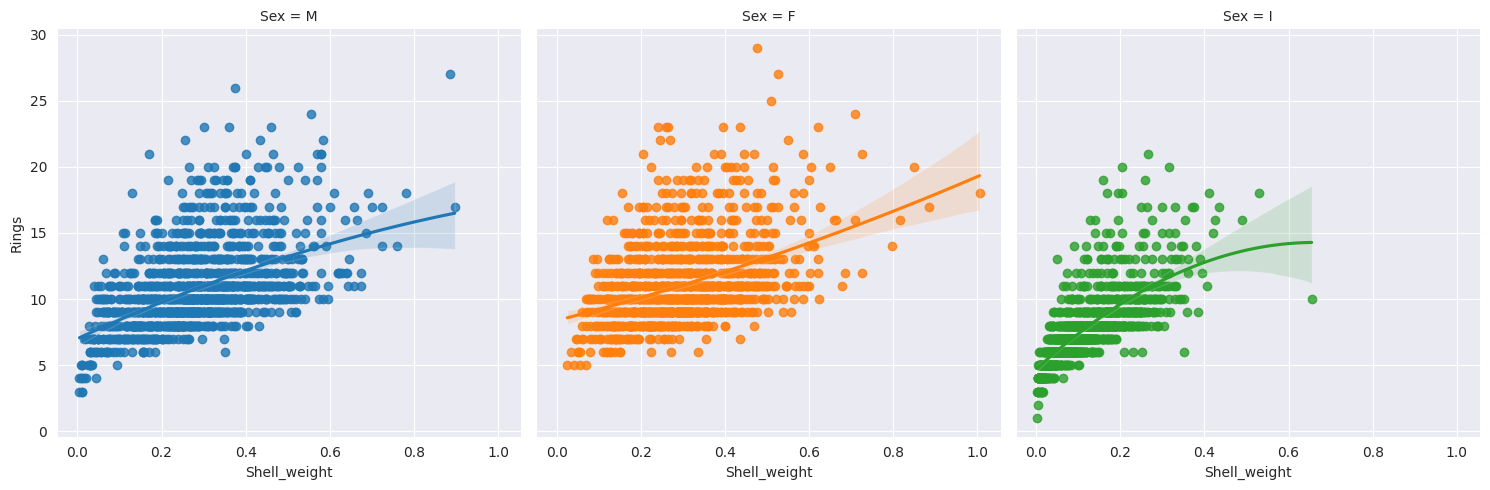

In [ ]:
# Create a FacetGrid with scatterplots
sns.lmplot(x="Shell_weight", y="Rings", hue="Sex", col="Sex", data=df);

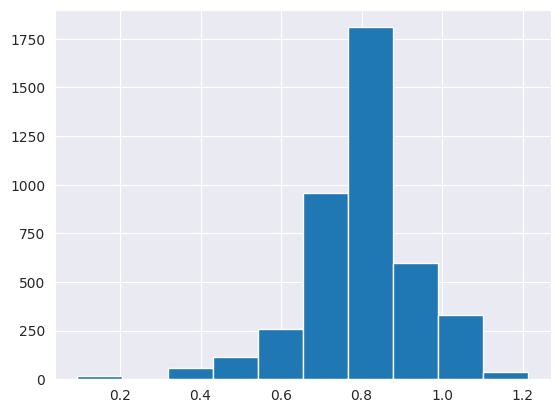

In [67]:
# Plot log of Y
plt.hist(np.log(y));

In [8]:
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Let's create a Pipeline to scale the data and find outliers using KNN Classifier
steps = [
('scale', StandardScaler()),
('LOF', LocalOutlierFactor(contamination=0.05))
]
# Fit and predict
outliers = Pipeline(steps).fit_predict(X)

# Add column
df['outliers'] = outliers

# Look at the top 3
# df.sort_values(by='outliers').head(3)
df.query('Rings < 3')

,Diameter,Height,Shucked_weight,Viscera_weight,Shell_weight,Sex_M,Sex_F,Sex_I,Diameter_2,Height_2,Shell_2,Rings,outliers
236,0.055,0.010,0.0010,0.0005,0.0015,0,0,1,0.003025,0.000100,0.000002,1,-1
719,0.100,0.025,0.0045,0.0040,0.0050,0,0,1,0.010000,0.000625,0.000025,2,1


## Regular Linear Regression

In [24]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error

df2 = df.query('Height < 0.3 and Rings > 2 and outliers != -1').copy()
X = df2.drop(['Rings', 'outliers'], axis=1)
y = np.log(df2['Rings'])

lr = LinearRegression()
lr.fit(X, y)

predictions = lr.predict(X)

df2['Predictions_ML'] = np.exp(predictions)
print(root_mean_squared_error(df2['Rings'], df2['Predictions_ML']))
print('\n')
df2.tail(10)

2.195895634730781




,Diameter,Height,Shucked_weight,Viscera_weight,Shell_weight,Sex_M,Sex_F,Sex_I,Diameter_2,Height_2,Shell_2,Rings,outliers,Predictions_ML
4166,0.365,0.115,0.2320,0.0885,0.1560,0,0,1,0.133225,0.013225,0.024336,10,1,8.341243
4167,0.380,0.125,0.2690,0.1265,0.1535,1,0,0,0.144400,0.015625,0.023562,9,1,8.993787
4168,0.400,0.125,0.2865,0.1230,0.1765,0,1,0,0.160000,0.015625,0.031152,8,1,9.285907
4170,0.430,0.130,0.3155,0.1955,0.2405,1,0,0,0.184900,0.016900,0.057840,10,1,10.553070
4171,0.430,0.155,0.4000,0.1720,0.2290,1,0,0,0.184900,0.024025,0.052441,8,1,10.052919
4172,0.450,0.165,0.3700,0.2390,0.2490,0,1,0,0.202500,0.027225,0.062001,11,1,10.878114
4173,0.440,0.135,0.4390,0.2145,0.2605,1,0,0,0.193600,0.018225,0.067860,10,1,9.985998
4174,0.475,0.205,0.5255,0.2875,0.3080,1,0,0,0.225625,0.042025,0.094864,9,1,11.115776
4175,0.485,0.150,0.5310,0.2610,0.2960,0,1,0,0.235225,0.022500,0.087616,10,1,9.957828
4176,0.555,0.195,0.9455,0.3765,0.4950,1,0,0,0.308025,0.038025,0.245025,12,1,10.181793


In [138]:
# Adjusted R²
from sklearn.metrics import r2_score

r2 = r2_score(df2['Rings'], df2['Predictions'])
n= df2.shape[0]
p = df2.shape[1] - 1
adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
print(f'R²: {r2}')
print(f'Adjusted R²: {adj_r2}')

R²: 0.5188178348108121
Adjusted R²: 0.5172353991549914


##Preparing Data with TensorDataset and DataLoader

In [10]:
df2 = df.query('Height < 0.3 and Rings > 2 and outliers != -1').copy()
X = df2.drop(['Rings', 'outliers'], axis=1)
y = np.log(df2[['Rings']])

# X and Y to Numpy
X = X.to_numpy()
y = y.to_numpy()


In [11]:
# Prepare with TensorData
# TensorData helps us transforming the dataset to Tensor object and prepare it for PyTorch Models
dataset = TensorDataset(torch.tensor(X).float(), torch.tensor(y).float())

input_sample, label_sample = dataset[0]
print(f'** Input sample: {input_sample}, \n** Label sample: {label_sample}')

** Input sample: tensor([0.3650, 0.0950, 0.2245, 0.1010, 0.1500, 1.0000, 0.0000, 0.0000, 0.1332,
        0.0090, 0.0225]), 
** Label sample: tensor([2.7081])


In [12]:
# Next, let's use DataLoader
batch_size = 1000
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

## Iterate
# for input_batch, label_batch in dataloader:
#   print(f'** Input batch: {input_batch}, \n**Label batch: {label_batch}')
#   break

## PyTorch Model

PyTorch models are also best defined as classes.
* The `class` is based on the nn.Module, PyTorch's base class for neural networks.
* We define the **model layers we want to use in the init method**.
* `super().__init__()` ensures the class will behave like a torch object.
* The `forward` method describes **what happens to the input when passed to the model**.

Here, we only pass it through Linear layers that we defined in the init method.

In [13]:
# 2. Creating a class
class AbaloneModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear1 = nn.Linear(in_features=X.shape[1], out_features=128)
    self.linear2 = nn.Linear(128, 64)
    self.linear3 = nn.Linear(64, 32)
    self.linear4 = nn.Linear(32, 1)

  def forward(self, x):
    x = self.linear1(x)
    x = nn.functional.relu(x)
    x = self.linear2(x)
    x = nn.functional.relu(x)
    x = self.linear3(x)
    x = nn.functional.relu(x)
    x = self.linear4(x)
    return x

In [14]:
# Instantiate model
model = AbaloneModel()

### Random Search for Best Learning Rate and Momentum

In [15]:
# Mean Squared Error (MSE) is standard for regression
criterion = nn.MSELoss()

# Random Search
values = []
best_loss = 999
for idx in range(1000):
  # Randomly sample a learning rate factor between 2 and 4
  factor = np.random.uniform(2,5)
  lr = 10 ** -factor

  # Randomly select a momentum between 0.85 and 0.99
  momentum = np.random.uniform(0.90, 0.99)

  # 1. Get Data
  feature, target = dataset[:]
  # 2. Zero Gradients: Clear old gradients before the backward pass
  optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
  # optimizer = optim.Adam(model.parameters(), weight_decay=lr)
  optimizer.zero_grad()
  # 3. Forward Pass: Compute prediction
  y_pred = model(feature)
  # 4. Compute Loss
  loss = criterion(y_pred, target)
  # 4.1 Register best Loss
  if loss < best_loss:
    best_loss = loss
    best_lr = lr
    best_momentum = momentum
    best_idx = idx

  # 5. Backward Pass: Compute gradient of the loss w.r.t W and b'
  loss.backward()
  # 6. Update Parameters: Adjust W and b using the calculated gradients
  optimizer.step()
  values.append([idx, lr, momentum, loss])

print(f'n: {idx},lr: {lr}, momentum: {momentum}, loss: {loss}')



n: 999,lr: 0.0018263925765495007, momentum: 0.9866724686242333, loss: 0.06227385997772217


In [16]:
# --- 3. Loss Function and Optimizer ---

# Mean Squared Error (MSE) is standard for regression
criterion = nn.MSELoss()

# Stochastic Gradient Descent (SGD) with a small learning rate (lr)
optimizer = optim.SGD(model.parameters(), lr=0.004, momentum=0.98)
# optimizer = optim.Adam(model.parameters(), weight_decay=0.0001)

In [17]:
# 4. Training
torch.manual_seed(42)
NUM_EPOCHS = 1001
loss_history = []
best_loss = 999

# Put model in training mode
model.train()

for epoch in range(NUM_EPOCHS):
  for data in dataloader:

    # 1. Get Data
    feature, target = data

    # 2. Zero Gradients: Clear old gradients before the backward pass
    optimizer.zero_grad()

    # 3. Forward Pass: Compute prediction
    y_pred = model(feature)

    # 4. Compute Loss
    loss = criterion(y_pred, target)
    loss_history.append(loss)

    # Get Best Model
    if loss < best_loss:
      best_loss = loss
      best_model_state = model.state_dict()  # save best model


    # 5. Backward Pass: Compute gradient of the loss w.r.t W and b'
    loss.backward()

    # 6. Update Parameters: Adjust W and b using the calculated gradients
    optimizer.step()

    # Load the best model before returning predictions
    model.load_state_dict(best_model_state)

  # Print status every 50 epochs
  if epoch % 200 == 0:
    print(epoch, loss.item())
    print(f'Best Loss: {best_loss}')


0 0.06410481035709381
Best Loss: 0.06082640588283539
200 0.037323132157325745
Best Loss: 0.03268168494105339
400 0.033134784549474716
Best Loss: 0.030819721519947052
600 0.032816704362630844
Best Loss: 0.030640309676527977
800 0.034733846783638
Best Loss: 0.02924901805818081
1000 0.03698249161243439
Best Loss: 0.02924901805818081


### Train and Test

In [26]:
# Get features
features, targets = dataset[:]

# Get Predictions
model.eval()
with torch.no_grad():
  predictions = model(features)

# Add to dataframe
df2['Predictions_DL'] = np.exp(predictions.detach().numpy())

# RMSE
print(root_mean_squared_error(df2['Rings'], df2['Predictions_DL']))

print('\n')
df2.tail(10)

2.1055636405944824




,Diameter,Height,Shucked_weight,Viscera_weight,Shell_weight,Sex_M,Sex_F,Sex_I,Diameter_2,Height_2,Shell_2,Rings,outliers,Predictions_ML,Predictions_DL
4166,0.365,0.115,0.2320,0.0885,0.1560,0,0,1,0.133225,0.013225,0.024336,10,1,8.341243,8.222453
4167,0.380,0.125,0.2690,0.1265,0.1535,1,0,0,0.144400,0.015625,0.023562,9,1,8.993787,8.531229
4168,0.400,0.125,0.2865,0.1230,0.1765,0,1,0,0.160000,0.015625,0.031152,8,1,9.285907,9.306773
4170,0.430,0.130,0.3155,0.1955,0.2405,1,0,0,0.184900,0.016900,0.057840,10,1,10.553070,10.780258
4171,0.430,0.155,0.4000,0.1720,0.2290,1,0,0,0.184900,0.024025,0.052441,8,1,10.052919,9.336207
4172,0.450,0.165,0.3700,0.2390,0.2490,0,1,0,0.202500,0.027225,0.062001,11,1,10.878114,10.635188
4173,0.440,0.135,0.4390,0.2145,0.2605,1,0,0,0.193600,0.018225,0.067860,10,1,9.985998,9.480294
4174,0.475,0.205,0.5255,0.2875,0.3080,1,0,0,0.225625,0.042025,0.094864,9,1,11.115776,10.828112
4175,0.485,0.150,0.5310,0.2610,0.2960,0,1,0,0.235225,0.022500,0.087616,10,1,9.957828,9.787364
4176,0.555,0.195,0.9455,0.3765,0.4950,1,0,0,0.308025,0.038025,0.245025,12,1,10.181793,11.095458


In [30]:
(
    df2[['Rings','Predictions_ML', 'Predictions_DL']].round(1)
    .rename(columns={'Predictions_ML':'Pred_sklearn', 'Predictions_DL':'Pred_PyTorch'})
    .sample(10)
)

,Rings,Pred_sklearn,Pred_PyTorch
3058,11,11.0,11.7
1061,6,5.4,5.2
861,12,10.2,9.7
3030,11,8.3,8.3
2626,4,4.8,4.5
3910,13,10.2,10.7
52,10,9.3,8.9
19,9,8.2,8.5
2374,12,8.3,8.4
480,29,11.4,12.1


In [32]:
# Improvement
(2.196 - 2.105)/2.196

0.04143897996357021